# Project 3 : Tennis 

## Setup 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Env/Tennis.x86_64",no_graphics=False)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Agents 

Let's define the models used for the actor and the critic of our two agents :

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state for one agent
            action_size (int): Dimension of each action for one agent
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state (for all agents)
            action_size (int): Dimension of each action (for all agents)
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Now it's time to define the actors. The DDPG_Agent class corresponds to one of the multiple agents. The collaboration between them is handled by the next class. 

In [3]:
## Parameters of the training
BUFFER_SIZE = int(1e6)   # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.2               # for soft update of target parameters
LR_ACTOR = 1*1e-4  # learning rate of the actor
LR_CRITIC = 1*1e-3       # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
EPSILON_DECAY=1
NB_UPDATES=5
LEARN_EVERY=1


In [4]:
### import numpy as np
import random
import copy


import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class DDPG_Agent():
    """ Agent that interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, nb_agents,random_seed,index=0,lr=LR_ACTOR,dec=EPSILON_DECAY):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            nb_agents (int) : number of agents in the environment
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.nb_agents=nb_agents
        self.index=torch.cuda.LongTensor([index])
        # Actor Network (w/ Target Network)
        #### The actor only sees its own state
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)        
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr)


        # Critic Network (w/ Target Network)
        #### The critic sees the whole state as well as the actions taken from the other agents
        self.critic_local = Critic(state_size*nb_agents, action_size*nb_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*nb_agents, action_size*nb_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.epsilon = 1
        self.decay = dec
    

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy.
        
        Params:
        =======
            state : state seen by the current agent
            add_noise (bool) : True if we add the UO noise
        """
        if(not torch.is_tensor(state)):
            state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action=(self.actor_local(state).cpu().data.numpy())
        self.actor_local.train()
        if add_noise:
            perturbation =self.noise.sample()*self.epsilon
            action += perturbation
        return np.clip(action, -1, 1)
              
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, proposed_actions, proposed_next_actions,gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Collect the informations from experiences
        states, actions, rewards, next_states, dones = experiences
        next_actions = torch.cat(proposed_next_actions, dim=1).to(device)
        # ---------------------------- update critic ---------------------------- #
        self.critic_optimizer.zero_grad()
        # Get predicted next-state actions and Q values from target models
        with torch.no_grad():
            Q_targets_next = self.critic_target(next_states, next_actions)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards.index_select(1,self.index) + (gamma * Q_targets_next * (1 - dones.index_select(1,self.index)))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        
        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())
        
        # Minimize the loss
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        ###### Guess an action
        self.actor_optimizer.zero_grad()

        actions_agent = [pa if i == self.index else pa.detach() for i, pa in enumerate(proposed_actions)]
        actions_agent = torch.cat(actions_agent, dim=1).to(device)
        actor_loss = -self.critic_local(states, actions_agent).mean()

        # Minimize the loss
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------------------ Reduce noise -------------------------- #
        self.epsilon*=self.decay
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)     
        
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def save(self):
        torch.save(self.actor_local.state_dict(), 'checkpoint_actor'+str(self.index.item())+'.pth')
        torch.save(self.critic_local.state_dict(), 'checkpoint_critic'+str(self.index.item())+'.pth')
    
    def load(self):
        self.critic_local.load_state_dict(torch.load('checkpoint_critic'+str(self.index.item())+'.pth'))
        self.actor_local.load_state_dict(torch.load('checkpoint_actor'+str(self.index.item())+'.pth'))
        self.critic_target.load_state_dict(torch.load('checkpoint_critic'+str(self.index.item())+'.pth'))
        self.actor_target.load_state_dict(torch.load('checkpoint_actor'+str(self.index.item())+'.pth'))



class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size=size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.normal(0,1,self.size)
        self.state = x + dx
        return self.state



### Collaboration

The MultiAgent Deep Deterministic Policy Gradient (MADDPG) class handles the collaboration between agents. It initializes n agents, handles the buffer replay for them, and call their act and learn methods. 

In [5]:
from collections import namedtuple, deque


class MADDPG():
    """  Deep Deterministic Policy Gradient (MADDPG) class handles the collaboration between agents. It initializes n agents, handles the buffer replay for them, and call their act and learn methods. """
    def __init__(self,state_size,action_size,nb_agents):
        """
        @param state_size(int) : dimension of the state encountered by one agent
        @param action_size(int): dimension of the actions taken by one agent
        @param nb_agents(int) : number of agents in the environment
        """
        random_seed=1
        # Environment parameters
        self.nb_agents=nb_agents
        self.state_size=state_size
        self.action_size=action_size
        # Initialize the Agents. Each agent must know the dimension of its own state_size and action_size, as well as the number of other agents in the envorionment (as the critic depends on it) and its index in the agents list.
        self.agents = [DDPG_Agent(state_size, action_size, nb_agents,random_seed,i) for i in range(0,nb_agents)]
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.steps=0
        self.gamma=GAMMA
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state.reshape(1,-1), action, reward, next_state.reshape(1,-1), done)
        self.steps+=1
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.steps>LEARN_EVERY:
            self.steps=0
            for _ in range(0,NB_UPDATES):
                # Each agent has to train : 
                # We start by sampling some experiences for each agents
                experiences = [self.memory.sample() for _ in range(0,self.nb_agents)]
                self.learn(experiences)

    def learn(self,experiences):
        # Use actor target network to guess the optimal next action 
        # Use actor local network to compute the optimal action from the current sate
        for i,agent_to_train in enumerate(self.agents):
            states, _, _, next_states, _ = experiences[i]
            next_actions=[]
            actions=[]
            for j,current_agent in enumerate(self.agents):
                agent_id = torch.tensor([j]).to(device)
                #Get the state and the next state seen by the current agent
                experience_state = states.reshape(-1, self.nb_agents, self.state_size).index_select(1, agent_id).squeeze(1)
                experience_next_state = next_states.reshape(-1, self.nb_agents, self.state_size).index_select(1, agent_id).squeeze(1)
                # Get the action with target network and current network
                agent_next_action = current_agent.actor_target(experience_next_state)
                agent_action = current_agent.actor_local(experience_state)
                actions.append(agent_action)
                next_actions.append(agent_action)
            agent_to_train.learn(experiences[i],actions,next_actions, self.gamma)
        
    def act(self,states):
        actions = [current_agent.act(states[i]) for i,current_agent in enumerate(self.agents)]
        return np.array(actions).reshape(1,-1)
    
    def reset(self):
        for a in self.agents:
            a.reset()
            
    def save(self):
        for agent in self.agents:
            agent.save()
    def load(self):
        for agent in self.agents:
            agent.load()

                    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)        
        
        

In [6]:
agent = MADDPG(24,2,2)


In [14]:
def train(random_steps=0):
    # Collect experience with pure random exploration
    scores_agent = deque(maxlen=100)  # last 100 scores
    print_every=25
    my_scores=[]
    for i in range(1,8001):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment   
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(2)                          # initialize the score (for each agent)
        while True:            
            actions=agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            agent.step(states, actions, rewards,next_states, dones)
            if np.any(dones):                                  # exit loop if episode finished
                break
            states = next_states  
            
        my_scores.append(np.max(scores))
        scores_agent.append(np.max(scores))

        if(np.mean(scores_agent)>0.5):
            print('Environment Solved in {} episodes!'.format(i-100))
            agent.save()
            break
        if (i%print_every==0):
            print('Ep. {} : Av score (max over agents) over 100 last episodes {}'.format(i, np.mean(scores_agent)))
            agent.save()
    return my_scores


## Train the agent
You may skip this part and directrly go to the next one to see a trained agent in action. 

/home/romain/.conda/envs/DRL/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep. 25 : Av score (max over agents) over 100 last episodes 0.004000000059604645
Ep. 50 : Av score (max over agents) over 100 last episodes 0.007800000123679638
Ep. 75 : Av score (max over agents) over 100 last episodes 0.005200000082453092
Ep. 100 : Av score (max over agents) over 100 last episodes 0.00490000007674098
Ep. 125 : Av score (max over agents) over 100 last episodes 0.003900000061839819
Ep. 150 : Av score (max over agents) over 100 last episodes 0.0010000000149011613
Ep. 175 : Av score (max over agents) over 100 last episodes 0.0010000000149011613
Ep. 200 : Av score (max over agents) over 100 last episodes 0.0
Ep. 225 : Av score (max over agents) over 100 last episodes 0.0
Ep. 250 : Av score (max over agents) over 100 last episodes 0.0
Ep. 275 : Av score (max over agents) over 100 last episodes 0.0010000000149011613
Ep. 300 : Av score (max over agents) over 100 last episodes 0.0020000000298023225
Ep. 325 : Av score (max over agents) over 100 last episodes 0.00290000004693865

Ep. 2600 : Av score (max over agents) over 100 last episodes 0.39400000596418977
Ep. 2625 : Av score (max over agents) over 100 last episodes 0.3489000052958727
Ep. 2650 : Av score (max over agents) over 100 last episodes 0.3453000052087009
Ep. 2675 : Av score (max over agents) over 100 last episodes 0.33080000497400763
Ep. 2700 : Av score (max over agents) over 100 last episodes 0.3439000051654875
Ep. 2725 : Av score (max over agents) over 100 last episodes 0.40070000605657696
Ep. 2750 : Av score (max over agents) over 100 last episodes 0.3805000057630241
Ep. 2775 : Av score (max over agents) over 100 last episodes 0.368600005581975
Ep. 2800 : Av score (max over agents) over 100 last episodes 0.38820000590756537
Ep. 2825 : Av score (max over agents) over 100 last episodes 0.34950000528246167
Ep. 2850 : Av score (max over agents) over 100 last episodes 0.3267000049352646
Ep. 2875 : Av score (max over agents) over 100 last episodes 0.31350000474601986
Ep. 2900 : Av score (max over agent

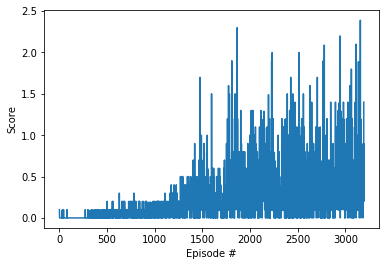

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()

scores = train()

ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


## Watch the agent

In [7]:
 


# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Load the agent
agent.load()

# Watch it 
scores_agent= []
my_scores=[]
print_every=1
for i in range(1,101):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(2)                          # initialize the score (for each agent)
        while True:            
            actions=agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
            states = next_states  
            
        my_scores.append(np.max(scores))
        scores_agent.append(np.max(scores))

        if (i%print_every==0):
            print('Ep. {} : Av score (max over agents) over 100 last episodes {}'.format(i, np.mean(scores_agent)))
        
env.close()

/home/romain/.conda/envs/DRL/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep. 1 : Av score (max over agents) over 100 last episodes 0.30000000447034836
Ep. 2 : Av score (max over agents) over 100 last episodes 0.245000003837049
Ep. 3 : Av score (max over agents) over 100 last episodes 0.8300000124921402
Ep. 4 : Av score (max over agents) over 100 last episodes 0.7475000112317502
Ep. 5 : Av score (max over agents) over 100 last episodes 0.6580000098794698
Ep. 6 : Av score (max over agents) over 100 last episodes 0.5966666756818692
Ep. 7 : Av score (max over agents) over 100 last episodes 0.625714295144592
Ep. 8 : Av score (max over agents) over 100 last episodes 0.5600000084377825
Ep. 9 : Av score (max over agents) over 100 last episodes 0.4977777852780289
Ep. 10 : Av score (max over agents) over 100 last episodes 0.49800000749528406
Ep. 11 : Av score (max over agents) over 100 last episodes 0.46181818876754155
Ep. 12 : Av score (max over agents) over 100 last episodes 0.4316666731610894
Ep. 13 : Av score (max over agents) over 100 last episodes 0.45230769910

KeyboardInterrupt: 

In [16]:
env.close()